In [1]:
import numpy as np, pandas as pd, tensorflow as tf

import matplotlib, seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline
sns.set_style('whitegrid')
matplotlib.rcParams.update({
    'figure.figsize': (10, 6), 'font.size': 16, 'axes.labelsize': 20, 'xtick.labelsize': 12,
    'ytick.labelsize': 12, 'font.family': 'Helvetica,Arial,sans-serif'
})
%config InlineBackend.figure_format = 'retina'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Machine Learning lab 8: convolutional neural networks
## Jake Rowland and Paul Herz

2017-12-04

> **Nota bene:** much of this introductory text that describes the classification task and dataset preparation is replicated from a previous project using the same dataset, so as to avoid unnecessary rewriting. Some of it is partially replicated but modified to reflect necessary differences, whereas others are wholly reproduced.

## 1. Introduction

In the [previous project](https://github.com/SMU-ML-2017/Project2/blob/5f8e5c582c25bd2920c13321593bd4c638ed1cae/ML%20Project%202.ipynb) using this dataset, we mainly visualized trends in the textual corpus, using statistical tools like tf-idf. In this lab, we will employ several recurrent neural network (RNN) architectures to classify reviews by reviewer-supplied rating (1-5 stars).

### 1.1 Background

*Partially reproduced from Lab 2*

We wanted to use a dataset that provided us a substantial and diverse corpus, but we wanted valuable, human-sourced metadata to accompany it. We found those criteria in the Amazon Fine Food Reviews dataset ([Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews)). It consists of user-authored reviews for food products on Amazon. The authoring user provides a 1-5 star rating, a short summary (or "title" to the review), and body text. Other users rate the review as "Helpful" or "Not Helpful."

This dataset was originally published on Stanford's [SNAP](http://snap.stanford.edu/data/web-FineFoods.html), and the authors of the dataset request that its source paper be cited, as below:

* J. McAuley and J. Leskovec. [http://i.stanford.edu/~julian/pdfs/www13.pdf](From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews.) WWW, 2013.

The paper's authors, McAuely and Leskovec from Stanford University, used this dataset originally to build a model to recommend food products to users based on taste. They modeled "how tastes change due to the very act of consuming more products—in other words, as users become more experienced" (McAuley and Leskovec). Their prediction task is far more ambitious than what we may eventually set out to accomplish; nonetheless, recommendation and prediction using such a "real-life" dataset can be very valuable (if done right).

Such content, user-authored reviews on a general-purpose commerce site, is valuable, as it is a (mostly) unfiltered and surprisingly candid reflection on the tastes of users (their opinions), and how those opinions are viewed by others (meta-opinions, i.e. the helpfulness scores).

### 1.2 Business case

Our prediction task targets star ratings, a variation of sentiment analysis, and ought to be able to predict the star rating (1-5) corresponding to the user-authored review text. This task may not seem practical at face value, since users already provide star ratings themselves. However, the predicted score could be compared against the one provided by the user as a datapoint for Amazon's spam detection algorithm. Some Amazon users (us included) can anecdotally attest that procedurally-generated "spambot" comments oftentimes seem "off"—in terms of word choice, and sometimes due to a misalignment between the apparent sentiment (e.g. "WOW great") and provided rating (1-star). Being able to find incongruous comments ourselves with this prediction task could lend greater statistical backing to our anecdotal suspicions regarding spam in Amazon reviews.

This algorithm no doubt resembles tools Amazon has already deployed into their vast moderation pipeline to combat review manipulation and automation. Our implementation is simply a proof-of-concept that quick development of such tools is feasible with average ability and consumer hardware. A strong case can be made for the practicality of this task, given that auto-moderation is already widely employed—including by Amazon (e.g. their Rekognition product is marketed for image moderation use cases). 

### 1.3 Serviceability

We believe that our algorithm should perform at or above 80% accuracy (based on our chosen evaluation criteria) to be considered useful. Unlike our previous references to "80%," this figure is not at all arbitrary here. Given that there are five categories (1-5 stars), it should be acceptable to misclassify one of every five reviews. However, this figure does not account for the distance of misclassifications. In a categorical problem, there is not necessarily any "distance" between categories, or at least no distance that the classifier is aware of: one-hot encoded categories have no hierarchy or relationship other than those the classifier can infer from the data. We experiment with an ordinal approach to reviews in this project, which may allow us to factor numerical error or "distance" into our evaluation: misclassifying a 1-star review as a 2-star review is more acceptable of a mistake than misclassifying it as a 5-star review.

## 2. The dataset: preprocessing and review

### 2.1 Dataset preparation

In the previous project using this dataset, we did not commit the dataset to our repository, but since then, we have had to cache training results and entire models to file, and have learned how to use Git LFS (Large File Storage) to commit everything to the repository. As such, the Amazon Fine Foods dataset is included in this repo for reproducibility and simplicity. If you have Git LFS installed ([instructions here](https://git-lfs.github.com)), the dataset as well as pretrained models should be cloned along with this notebook. Otherwise, you will have to manually place the `Reviews.csv` file in the `data/` directory.

In [2]:
# `None` for full dataset, fraction (e.g. `0.5`) for subsample.
SAMPLE_RATE = None

In [3]:
reviews = pd.read_csv('data/Reviews.csv')
print(f'{reviews.shape[0]:,} Amazon reviews total.')
if SAMPLE_RATE is not None:
    reviews = reviews.sample(frac=SAMPLE_RATE)
    print(f'Subsampling to {reviews.shape[0]:,}.')

568,454 Amazon reviews total.


After the dataset identifier (`Id`), we have several domain-specific identifiers: `ProductId` and `UserId` point to internal resources within Amazon's backend: data models representing products (here, the reviewed product) and users (here, the authoring user). `ProfileName` simply consists of the screen names users have assigned themselves.

`HelpfulnessNumerator` and `-Denominator` are how the "up-" and "down-" votes have been codified in this dataset, where $\text{HelpfulnessNumerator}=\text{UpVotes}$ and $\text{HelpfulnessDenominator}=\text{UpVotes}+\text{DownVotes}$.

`Score` is an integer 1-5 representing the number of graphical "stars" the authoring user selected in the review form, and it is the "score" they have consigned the product to.

`Time` is a timestamp in [POSIX format](https://en.wikipedia.org/wiki/Unix_time) (also known as UNIX epoch time), that is, codified as seconds since `1970-01-01 T00:00:00Z` (UTC).

`Summary` and `Text` are the two fields relevant to the textual analysis we will perform in this document, however, it should be noted that summaries are invariably brief ("one-liners") whereas body text is diverse and oftentimes great in length.

### 2.2 Data quality

This data quality section is much briefer than the equivalent section in Project 2: we are only using text and scores in our prediction task, so we remove most columns. The data quality evaluation regarding helpfulness ratings have been removed accordingly.

In [4]:
for column in [
    'ProfileName', 'Summary', 'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 'Time', 'ProductId', 'UserId'
]:
    try:
        del reviews[column]
    except KeyError:
        print('No such column')

In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 3 columns):
Id       568454 non-null int64
Score    568454 non-null int64
Text     568454 non-null object
dtypes: int64(2), object(1)
memory usage: 13.0+ MB


Null cells are not the only indicator of completeness, but they are the most readily available. Bearing in mind the size of the current subsampled dataset, let's see how many null cells are present.

In [6]:
reviews.isnull().sum().sort_values(ascending=False)

Text     0
Score    0
Id       0
dtype: int64

We make 1-5 scores 0-based:

In [7]:
reviews['Score'] -= 1

The dataset, in its final form (before tokenization, etc.) is simply `Text` (review body) and `Score` (0-4 integers representing 1-5 star ratings)

### 2.3 Preprocessing

#### Tokenization

Here, we convert the top 120,000 words into integer tokens.

In [8]:
%%time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 120_000
LENGTH_PERCENTILE = 0.85

max_review_length = int(reviews['Text'].str.len().quantile(q=LENGTH_PERCENTILE))

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(reviews['Text'])
sequences = tokenizer.texts_to_sequences(reviews['Text'])

word_index_length = len(tokenizer.word_index)
top_words = min(word_index_length, MAX_WORDS)
X = pad_sequences(sequences, maxlen=max_review_length)

print(f'Found {word_index_length} unique tokens. Distilled to {top_words} top words.')
print(f'X.shape = {X.shape}\n')

Using TensorFlow backend.


Found 133039 unique tokens. Distilled to 120000 top words.
X.shape = (568454, 715)

CPU times: user 43.1 s, sys: 769 ms, total: 43.9 s
Wall time: 43.9 s


#### Ordinal or categorical approach

We initially approached our task, of predicting ratings, by representing ratings categorically. Categories were represented in one-hot encoded format. This removed our ability to "show" the classifier an explicit hierarchy or distance between categories, instead allowing it to learn the implicit hierarchy of the ratings.

By switching to an ordinal approach, the classifier can misclassify reviews more "gracefully." Ideally misclassifications are only off by one star distance, a concept which is not technically possible in a purely categorical system. We ordinally represent ratings and then round predicted values to retrieve categorization at the end of prediction.

In [9]:
ordinal = True

In [10]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets

if ordinal:
    y = reviews['Score'] / 5
else:
    y = keras.utils.to_categorical(reviews['Score'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2,
    stratify = reviews['Score']
)

if ordinal:
    y_cat = y_test*5
    loss='mean_squared_error'
    NUM_CLASSES = 1
else:
    loss='categorical_crossentropy'
    NUM_CLASSES = y.shape[1]

#### Embedding

We load the GloVe Word Embedding

In [11]:
%%time

EMBED_SIZE = 100

# the embed size should match the file you load glove from
embeddings_index = {}

# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
with open('embeddings/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index):,} word vectors.')

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((word_index_length + 1, EMBED_SIZE))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400,000 word vectors.
CPU times: user 6.93 s, sys: 128 ms, total: 7.06 s
Wall time: 7.05 s


## 3. Evaluation, training, and testing

### 3.1 Evaluation criteria

We use confusion matrices rather than a single scalar figure to best visualize the interaction between classes at different subsampling percentages. Invariably, larger samples perform better. We did not end up employing a criteria compatible with our ordinal classification scheme, but this methodology is a valuable method of showing if errors are in adjacent rating categories.

### 3.2 Train/test methodology

We don't use cross-validation due to the limitations of our compute platform in training an RNN, a much slower process than prior architectures. Instead, we turn to an 80-20 train-test split for reliability. This is not unrealistic compared to Amazon's theoretical moderation environment, where continual new reviews would be classified and compared to a static validation set.

In [12]:
def normalize_confusion_matrix(conf):
    return conf/np.amax(conf, axis=0)

def confusion_matrix_graph(yhat,y,title='Untitled'):
    conf = confusion_matrix(yhat,y)
    matrix_graph(conf,title)

def matrix_graph(matrix,title='Untitled'):
    ratings=[1,2,3,4,5]
    sns.heatmap(matrix,annot=True,fmt='f',xticklabels=ratings,yticklabels=ratings)
    plt.title(title)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    acc = matrix.diagonal().sum() / matrix.sum()
    print(f'Accuracy: {acc:1.4}')

## 4. Modeling

We compare two RNN models, one with GRU and another with LSTM. First, we establish common components for both architectures, namely the embedding layer, using the weights from the GloVe embedding we loaded earlier.

In [13]:
from keras.layers import Embedding

embedding = Embedding(
    word_index_length + 1,
    EMBED_SIZE,
    weights = [embedding_matrix],
    input_length = max_review_length,
    trainable = True
)

Below is a very useful function (`cache_fit`) that wraps Keras fitting with cache-to-file functionality. If the HDF5 (`.h5`) file for the model does not exist, the function trains the model from scratch and saves it to file with Keras's recommended `.save` method (not `pickle`). If it already exists, it is reloaded and deserialized.

In [14]:
import os.path
from keras.models import load_model
import json

def cache_fit(model_name: str, model, *args, **kwargs):
    archive_name = f'{model_name}_model.h5'
    history_name = f'{model_name}_history.json'
    archive_exists = os.path.isfile(archive_name)

    if not archive_exists:
        print(f'Model {model_name} not found in archive. Training new model.')
        hist = model.fit(*args, **kwargs)
        model.save(archive_name)
        with open(history_name, 'w') as f:
            json.dump(hist.history, f)
        return model
    else:
        print('Model found on disk. Reloading.')
        return load_model(archive_name)

Below is a function to derive the nearest categorical value from the ordinal prediction. This helps the accuracy of the neural network by allowing a tolerance, in this case $\pm.1$, when comparing the actual and the predicted values. This function also asists in visualizing the resulting ordinal output.

In [15]:
def star_from_ordinal(ordinal):
    star = []
    for value in ordinal:
        if value < .1:
            star.append(0)
        elif value >= .1 and value < .3:
            star.append(1)
        elif value >= .3 and value < .5:
            star.append(2)
        elif value >= .5 and value < .7:
            star.append(3)
        elif value >= .7:
            star.append(4)
    return np.asarray(star)

### 4.1 RNN architecture (GRU)
The below confusion matrices are the results of prior tests on 80-20 train-test splits. The results were saved in text format, so the matrices are in literal form.

In [16]:
%%time

from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, MaxPooling1D, Dense, GRU

gru = Sequential([
    embedding,
    
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    
    BatchNormalization(),
    
    GRU(100,dropout=0.25, recurrent_dropout=0.2),
    Dense(64),
    Dense(64),
    Dense(NUM_CLASSES, activation='sigmoid')
])
gru.compile(
    loss=loss,
    optimizer='Adam', 
    metrics=['accuracy']
)
gru.summary()

gru = cache_fit(
    'gru', gru, 
    X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 715, 100)          13304000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 715, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 357, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 357, 64)           6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 178, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 178, 64)           12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 89, 64)            0         
__________

#### 4.1.1 Categorical Performance

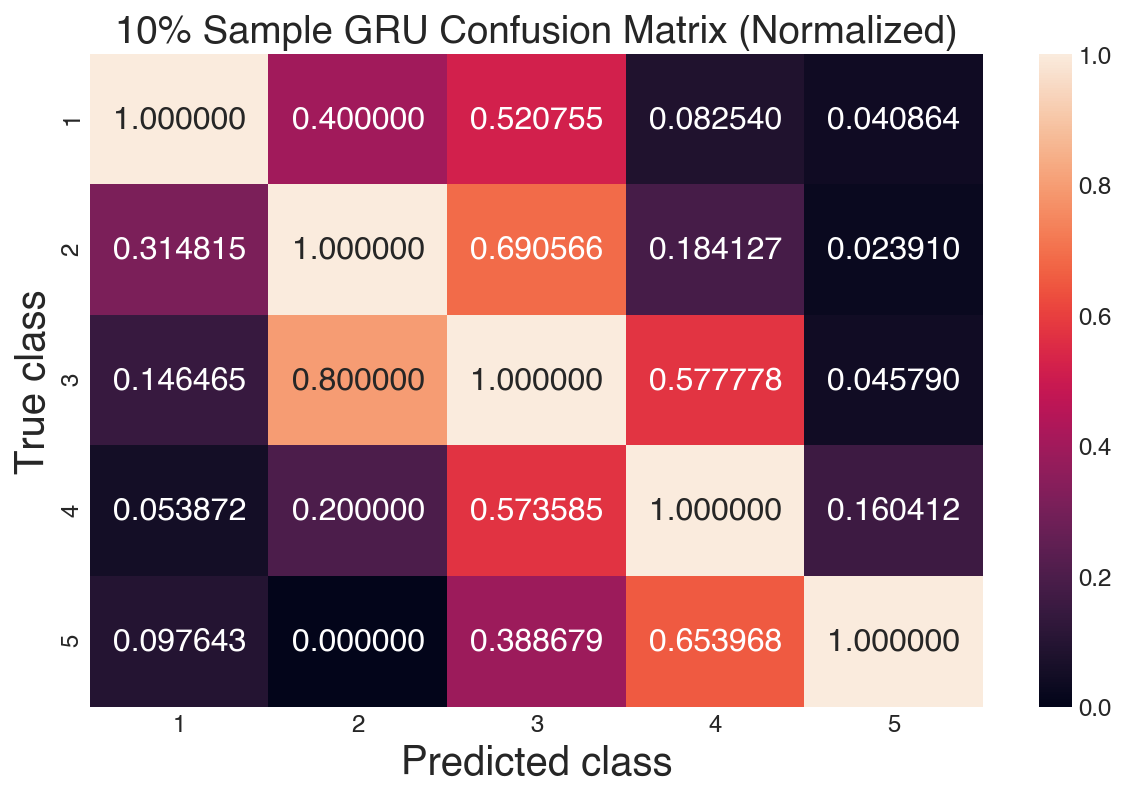

Accuracy: 0.4564


In [17]:
matrix_graph(normalize_confusion_matrix(
    [[594,2,138,26,282],
    [187,5,183,58,165],
    [87,4,265,182,316],
    [32,1,152,315,1107],
    [58,0,103,206,6901]]
), title='10% Sample GRU Confusion Matrix (Normalized)')

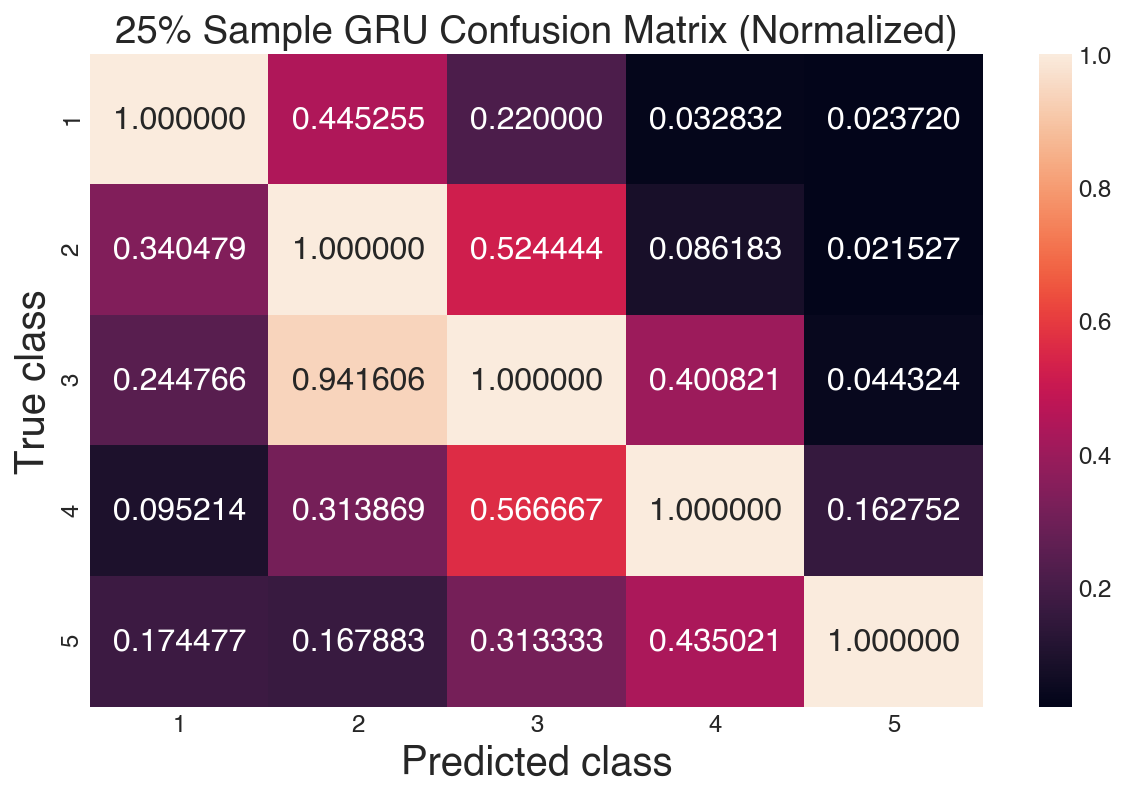

Accuracy: 0.4737


In [18]:
matrix_graph(normalize_confusion_matrix(
    [[ 2006, 61, 99, 24, 411],
    [  683, 137, 236, 63, 373],
    [  491, 129, 450, 293, 768],
    [  191, 43, 255, 731, 2820],
    [  350, 23, 141, 318, 17327]]
), title='25% Sample GRU Confusion Matrix (Normalized)')

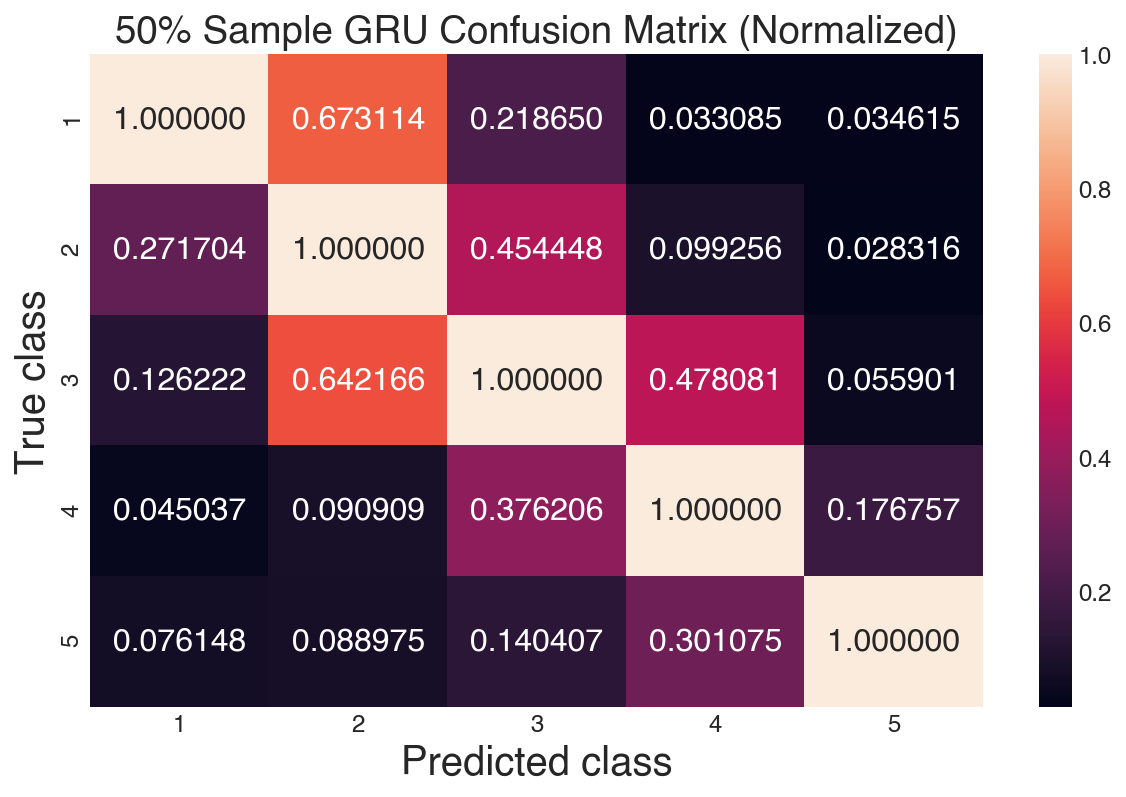

Accuracy: 0.5313


In [19]:
matrix_graph(normalize_confusion_matrix(
    [[ 3375, 348, 204, 40, 1231],
    [  917, 517, 424, 120, 1007],
    [  426, 332, 933, 578, 1988],
    [  152, 47, 351, 1209, 6286],
    [  257, 46, 131, 364, 35563]]
), title='50% Sample GRU Confusion Matrix (Normalized)')

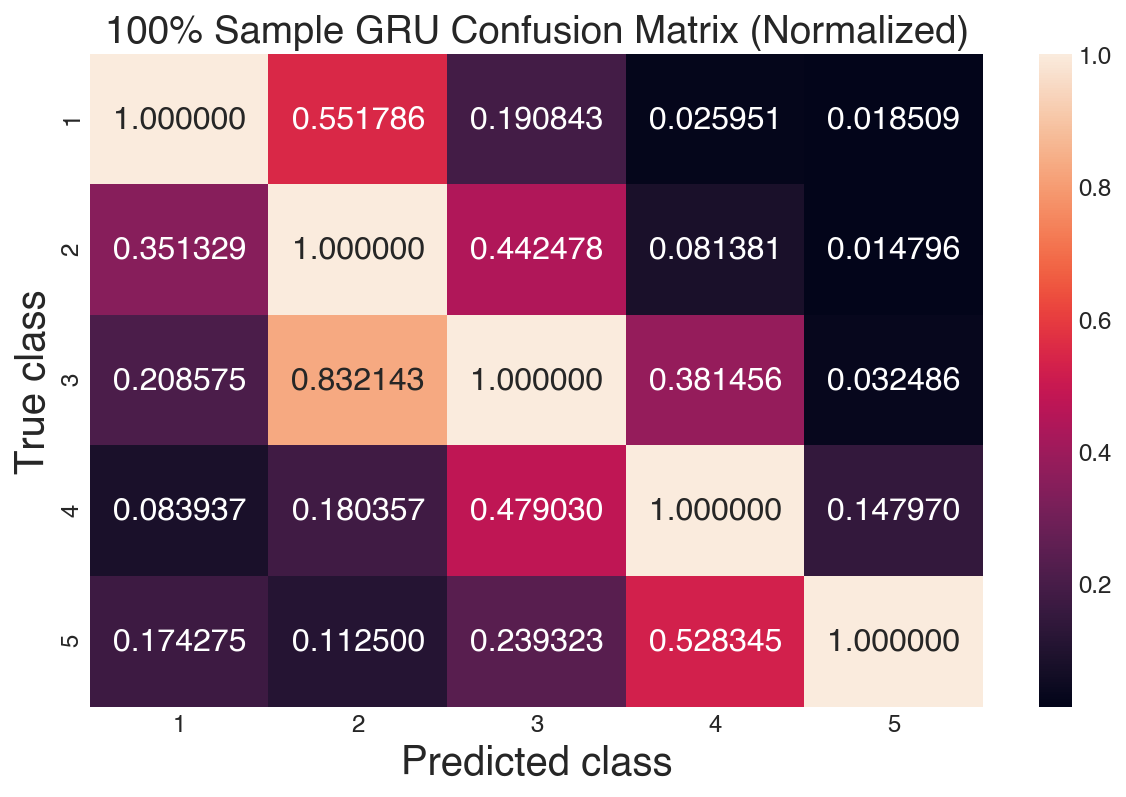

Accuracy: 0.4962


In [20]:
matrix_graph(normalize_confusion_matrix(
    [[ 8280, 309, 496, 103, 1266],
    [ 2909, 560, 1150, 323, 1012],
    [ 1727, 466, 2599, 1514, 2222],
    [  695, 101, 1245, 3969, 10121],
    [ 1443, 63, 622, 2097, 68399]]
), title='100% Sample GRU Confusion Matrix (Normalized)')

#### 4.1.2 Ordinal Performance

In [33]:
from sklearn.metrics import confusion_matrix

gru_y_hat = gru.predict(X_test)
gru_star = star_from_ordinal(gru_y_hat)

gru_cm = confusion_matrix(y_cat, gru_star)

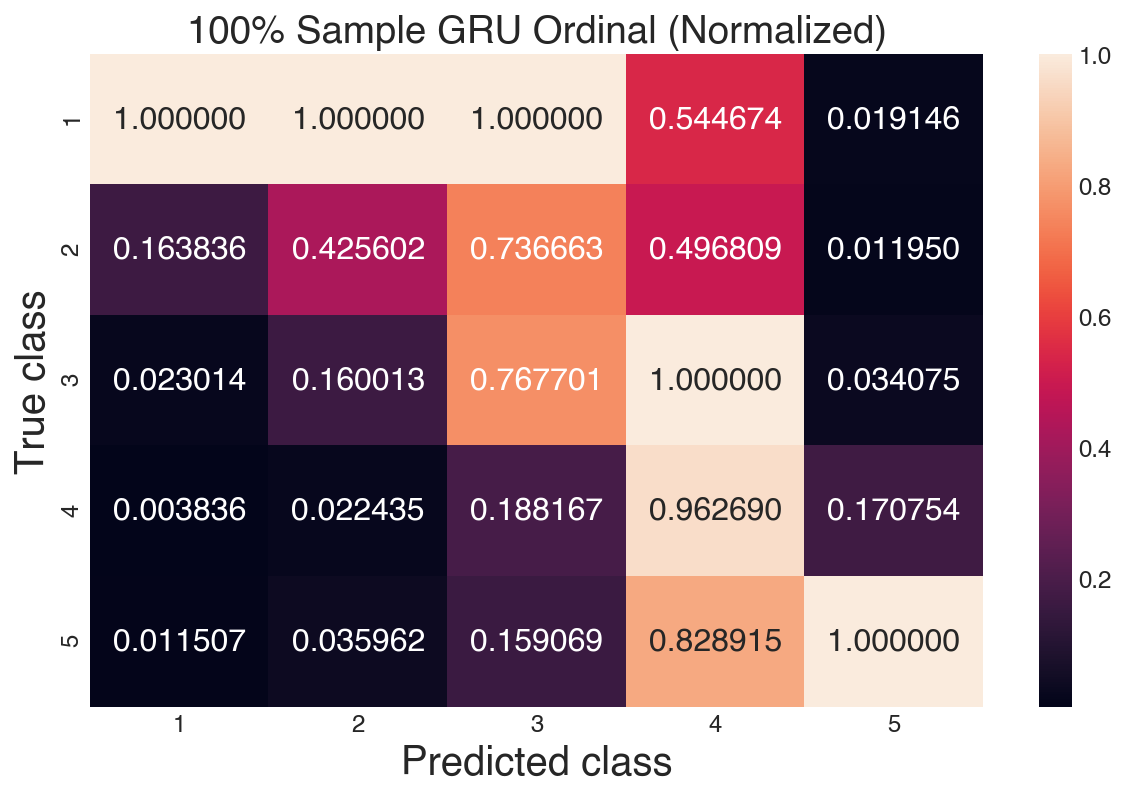

Accuracy: 0.386


In [ ]:
matrix_graph(normalize_confusion_matrix(
    gru_cm
), title='100% Sample GRU Ordinal (Normalized)')

We initally thought that ordinal would perform better becuase the model would have some idea that 1-Star is the worst, 2-Star is between 1-Star and 3-Star, etc., however, that was not the case. In this case specifically, only 2 of the five categories had the most predictions in the correct graph, the other three had more singular predictions in completelly wrong classes

### 4.2 RNN architecture (LSTM)

In [23]:
%%time

from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, MaxPooling1D, Dense, LSTM

lstm = Sequential([
    embedding,
    
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    
    BatchNormalization(),
    
    LSTM(100,dropout=0.25, recurrent_dropout=0.2),
    Dense(64),
    Dense(64),
    Dense(NUM_CLASSES, activation='sigmoid')
])

lstm.compile(
    loss=loss,
    optimizer='Adam', 
    metrics=['accuracy']
)
lstm.summary()

lstm = cache_fit(
    'lstm', lstm, 
    X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=32
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 715, 100)          13304000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 715, 32)           9632      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 357, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 357, 64)           6208      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 178, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 178, 64)           12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 89, 64)            0         
__________

#### 4.2.1 Categorical Performance

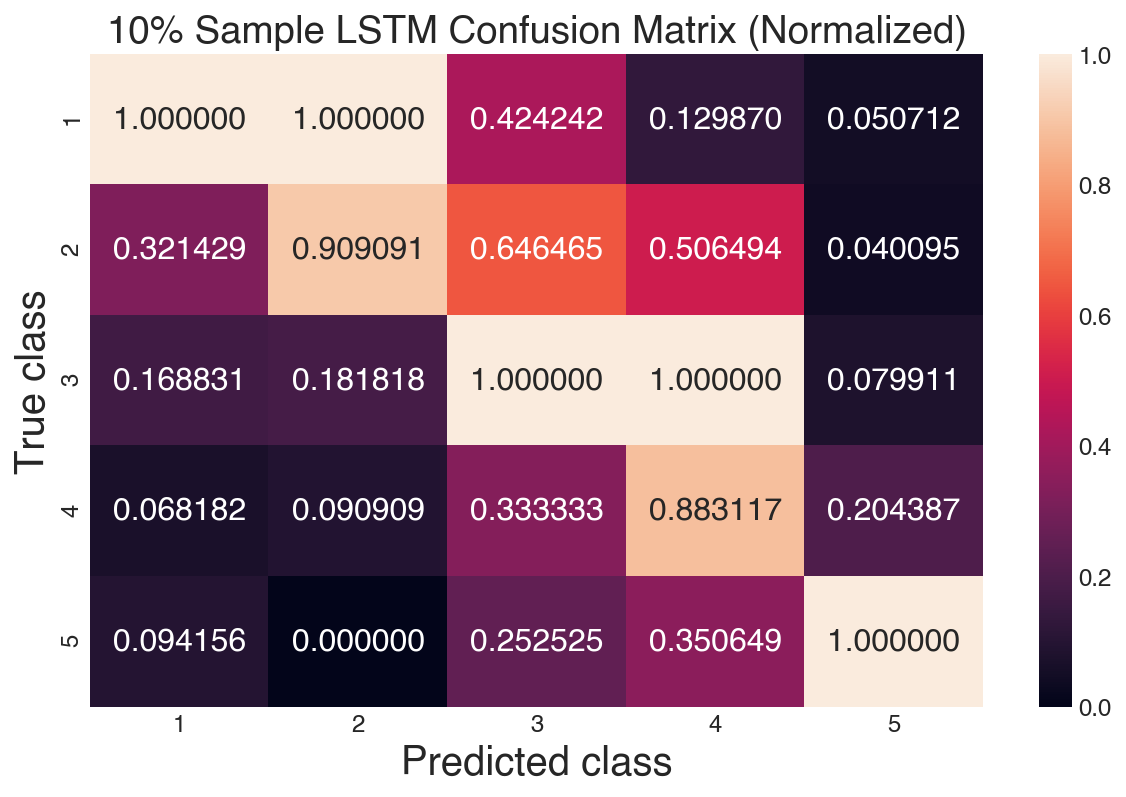

Accuracy: 0.4464


In [24]:
matrix_graph(normalize_confusion_matrix(
    [[ 616, 11, 42, 10, 363],
    [ 198, 10, 64, 39, 287],
    [ 104, 2,  99, 77, 572],
    [  42, 1,  33, 68, 1463],
    [  58, 0,  25, 27, 7158]]
), title='10% Sample LSTM Confusion Matrix (Normalized)')

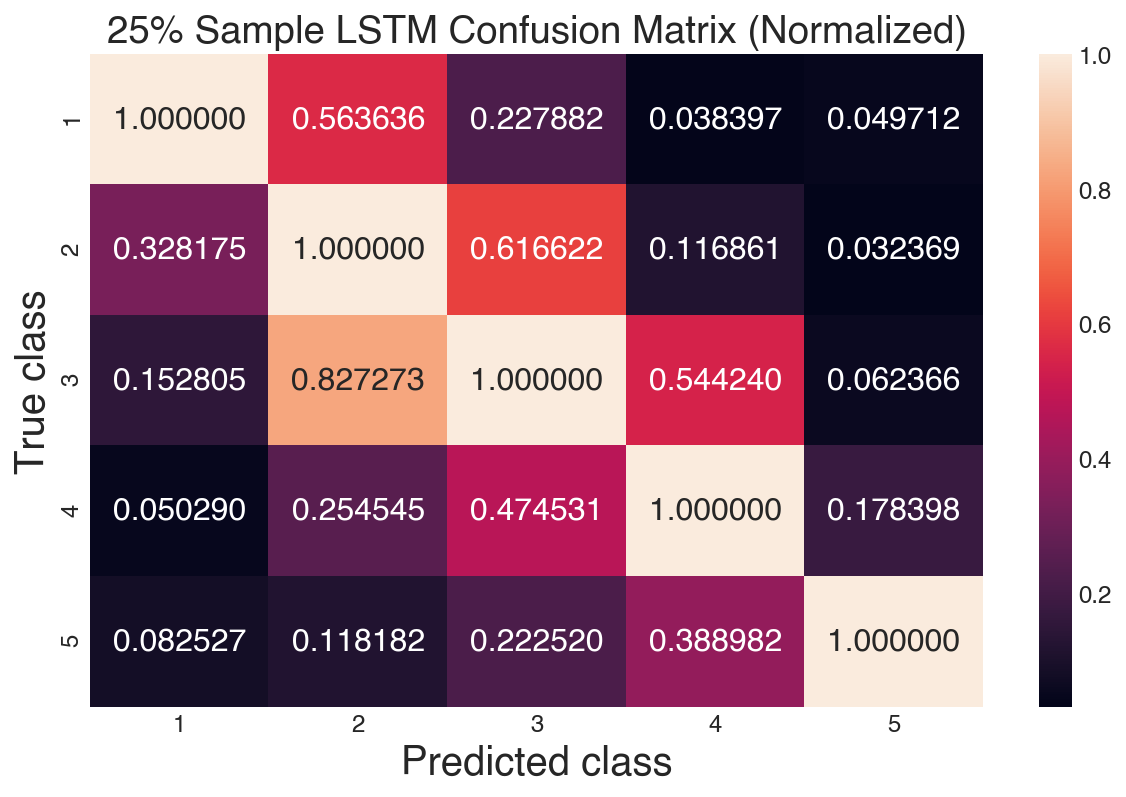

Accuracy: 0.484


In [25]:
matrix_graph(normalize_confusion_matrix(
    [[ 1551, 62, 85, 23, 880],
    [  509, 110, 230, 70, 573],
    [  237, 91, 373, 326, 1104],
    [   78, 28, 177, 599, 3158],
    [  128, 13, 83, 233, 17702]]
), title='25% Sample LSTM Confusion Matrix (Normalized)')

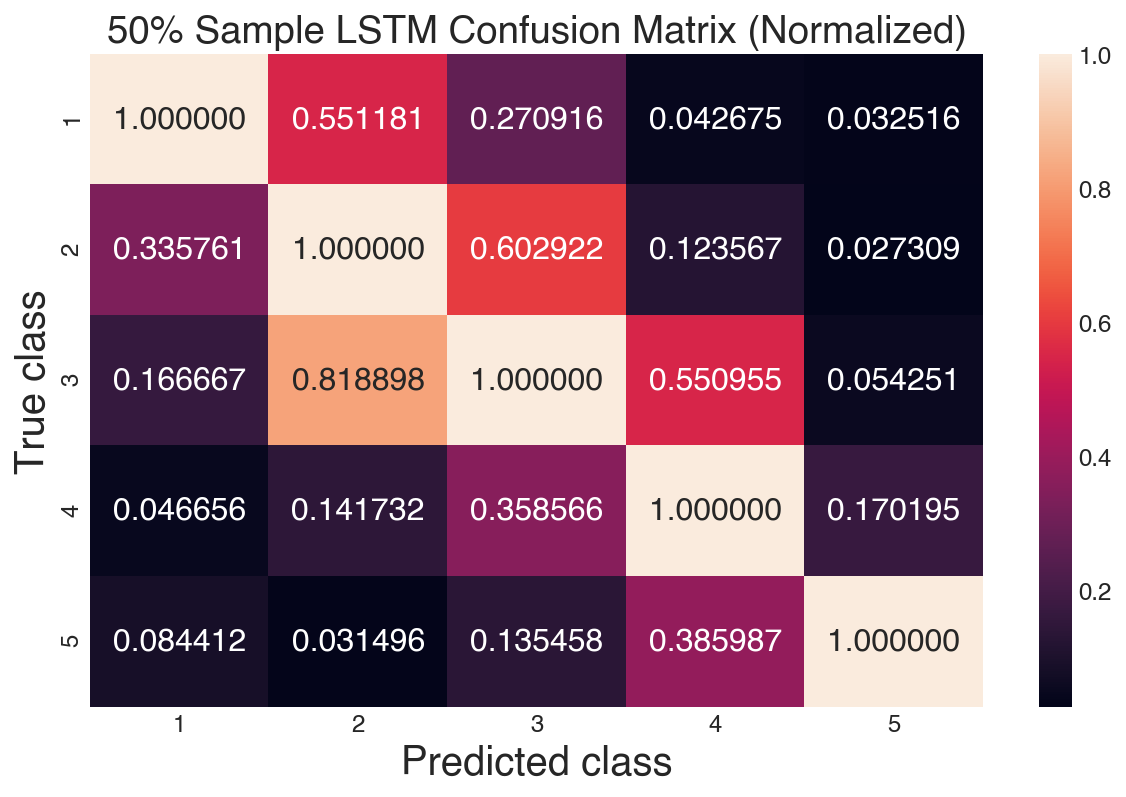

Accuracy: 0.5034


In [26]:
matrix_graph(normalize_confusion_matrix(
    [[ 3708, 70, 204, 67, 1149],
    [ 1245, 127, 454, 194, 965],
    [  618, 104, 753, 865, 1917],
    [  173,  18, 270, 1570, 6014],
    [  313,   4, 102, 606, 35336]]
), title='50% Sample LSTM Confusion Matrix (Normalized)')

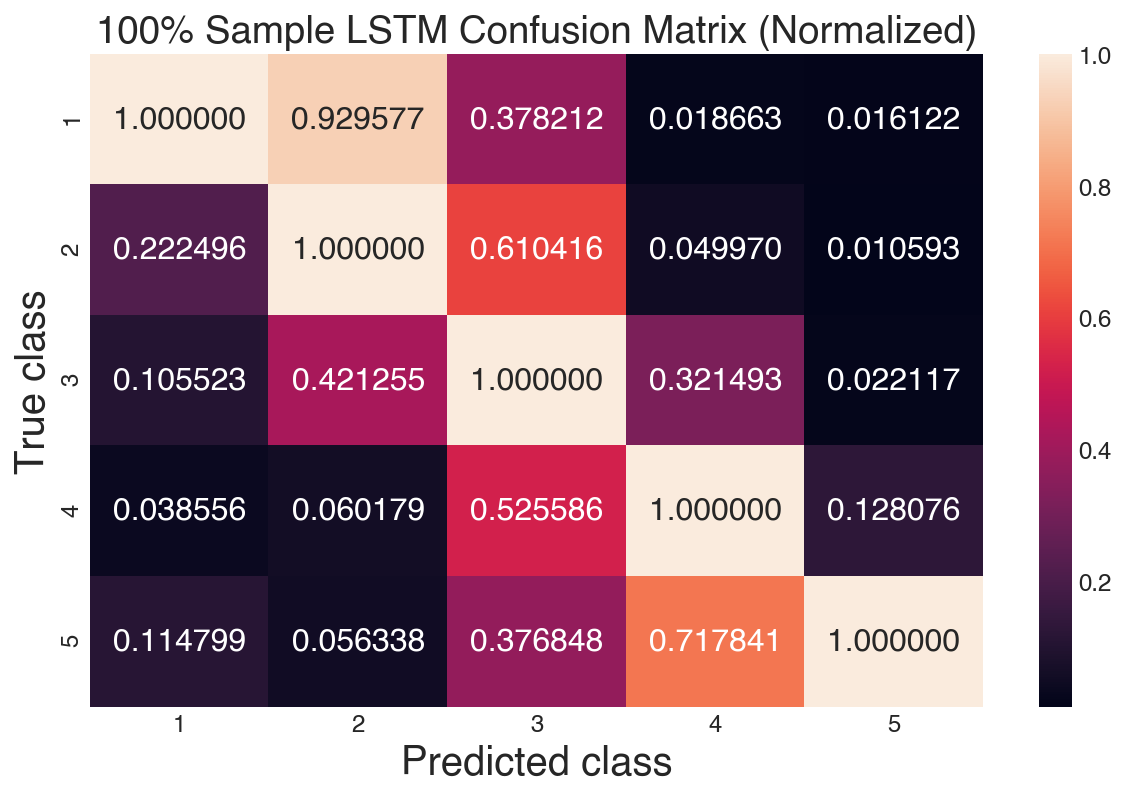

Accuracy: 0.4938


In [27]:
matrix_graph(normalize_confusion_matrix(
    [[ 6899, 726, 1663, 93, 1073],
    [ 1535, 781, 2684, 249, 705],
    [  728, 329, 4397, 1602, 1472],
    [  266, 47, 2311, 4983, 8524],
    [  792, 44, 1657, 3577, 66554]]
), title='100% Sample LSTM Confusion Matrix (Normalized)')

#### 4.2.2 Categorical Performance with Trained Embedding

These are the results of training the embedding beyond the initial weights loaded from the GloVe archive. The confusion matrices were only saved in text format so they are reproduced below as literals.

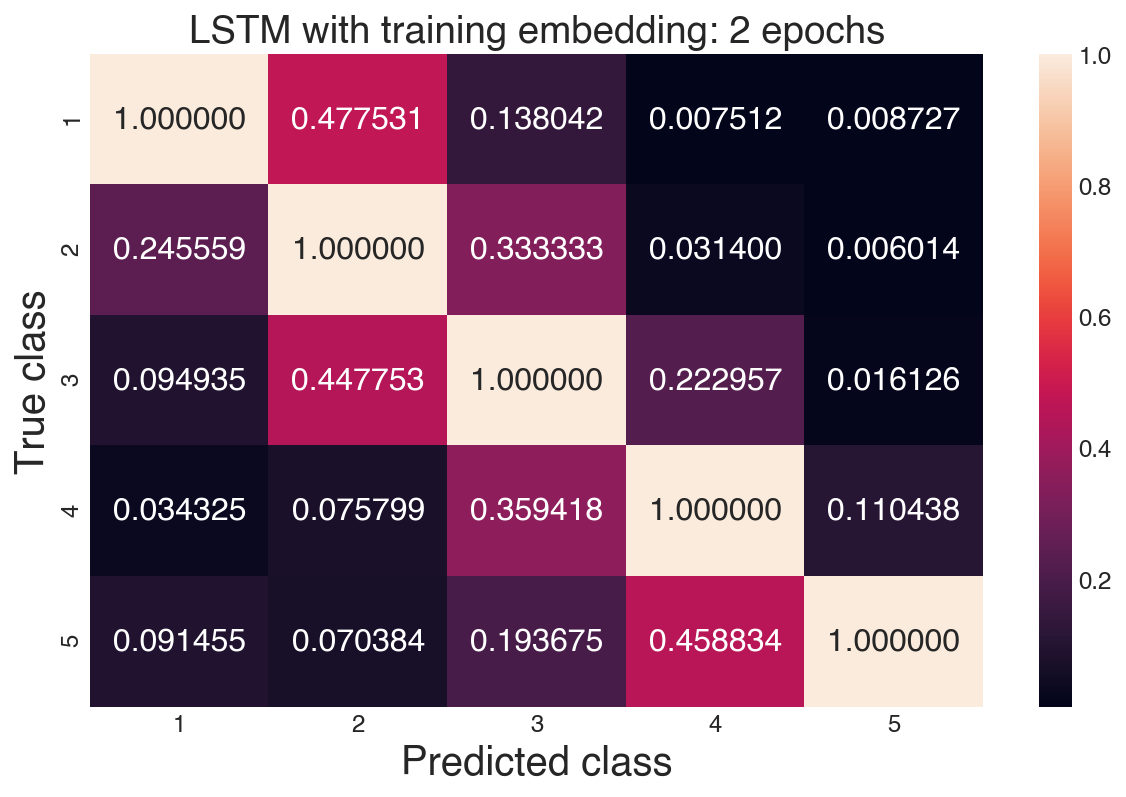

Accuracy: 0.5935


In [28]:
matrix_graph(normalize_confusion_matrix(
    [[ 8332, 882, 598, 50, 592],
    [ 2046, 1847, 1444, 209, 408],
    [  791, 827, 4332, 1484, 1094],
    [  286, 140, 1557, 6656, 7492],
    [  762, 130, 839, 3054, 67839]]
), title='LSTM with training embedding: 2 epochs')

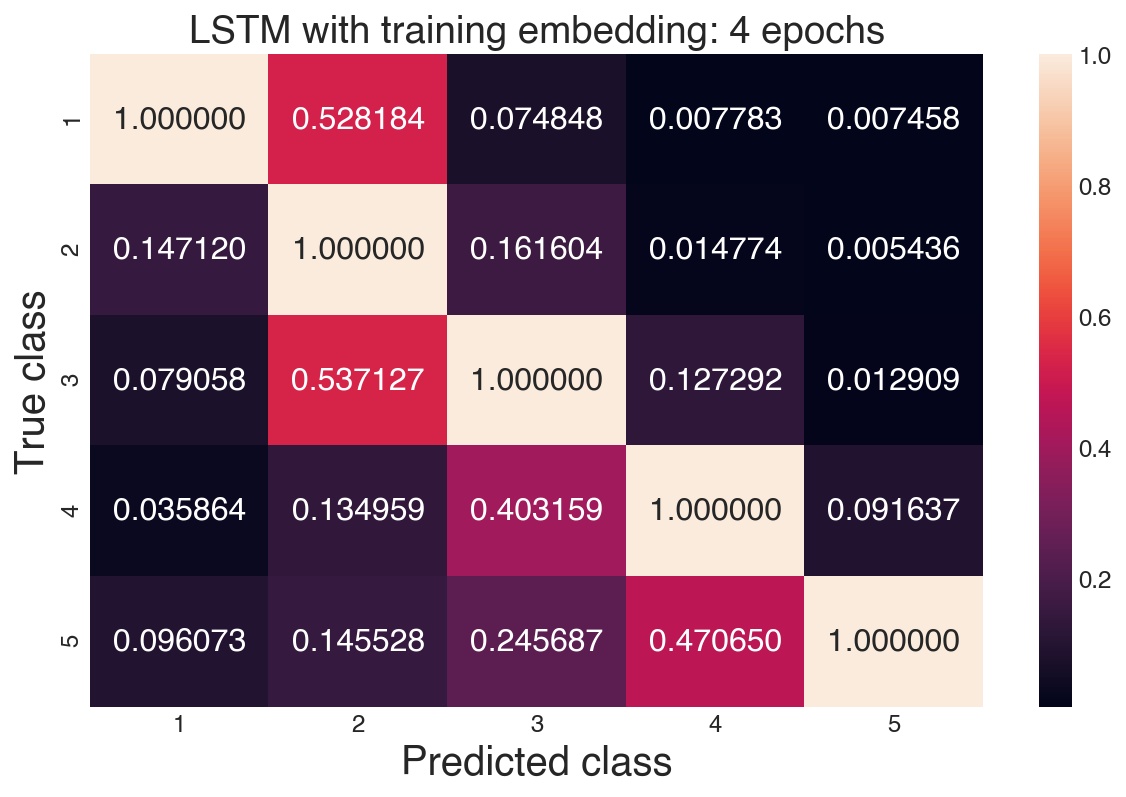

Accuracy: 0.6004


In [29]:
matrix_graph(normalize_confusion_matrix(
    [[ 7640, 1949, 308, 59, 498],
    [ 1124, 3690, 665, 112, 363],
    [  604, 1982, 4115, 965, 862],
    [  274, 498, 1659, 7581, 6119],
    [  734, 537, 1011, 3568, 66774]]
), title='LSTM with training embedding: 4 epochs')

When we trianed the embedding and the model at the same time we were able to improve out original accuracy by 10 points. This resulted in our model achieving an accuracy of 60% instead of ~50% when no training of the embedding was used. Even with the trained embedding, we were not able to achieve the 80% accuracy we desired.

#### 4.2.3 Ordinal Performance

In [ ]:
lstm_y_hat = lstm.predict(X_test)
lstm_star = star_from_ordinal(lstm_y_hat)

lstm_cm = confusion_matrix(y_cat, lstm_star)

In [ ]:
matrix_graph(normalize_confusion_matrix(
    lstm_cm
), title='100% Sample LSTM Ordinal (Normalized)')

Ordinal did not perform any better then a categorical representation of stars. Looking at the heat map reveals some interesting attributes about the ordinal distribution however. On a quick glance, the heat map almost resembles an upside down sigmoid graph. I attribute this feature to the final activation function being a sigmoid function.

## 5. Conclusion

We are not particularly impressed by the performance of our RNN architectures in their final form, only achieving ~50% accuracy on a five-category dataset, and ~60% with a trained embedding. This could probably be improved upon with some minor tuning, but we were limited in the number of iterations on training we could perform due to lengthened training times.